In [7]:
import urllib.request  # Import the necessary module

# Correct URL to directly access the Pima Indians Diabetes dataset CSV file
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
csv_path = '/content/pima-indians-diabetes.csv'

# Download the dataset
print("Downloading dataset...")
urllib.request.urlretrieve(url, csv_path)
print("Download completed!")

# Load the dataset into a pandas DataFrame
import pandas as pd

# Define column names for the dataset (based on the dataset description)
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Load the CSV file into a DataFrame
data = pd.read_csv(csv_path, names=columns)

# Display the first few rows of the dataset
data.head()

Download completed!


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data Preprocessing

In [8]:
# Step 2: Data Preprocessing

# 1. Check for missing values
print("Checking for missing values...")
missing_values = data.isnull().sum()
print(missing_values)

# Since there are no missing values in the dataset, we can skip this part. If there were any,
# we could either drop rows or fill them with mean/median values.

# 2. Normalize/Scale the numerical features
from sklearn.preprocessing import StandardScaler

# Extract the feature columns and the target (Outcome)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Initialize the scaler
scaler = StandardScaler()

# Normalize the feature data
X_scaled = scaler.fit_transform(X)

# 3. Split the dataset into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Checking for missing values...
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Training set shape: (614, 8), Testing set shape: (154, 8)


Train a Baseline Model

In [9]:
# Step 3: Train a Baseline Model (Logistic Regression)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.7532
Confusion Matrix:
[[79 20]
 [18 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



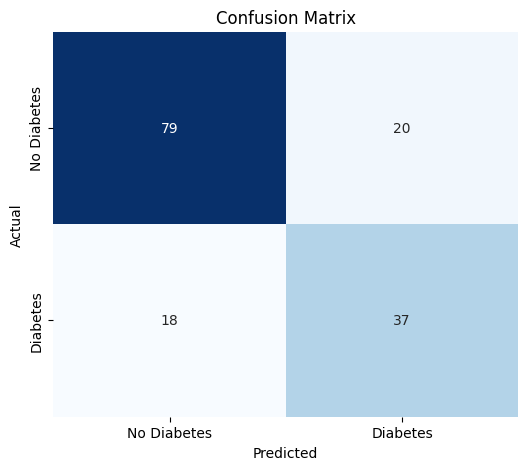

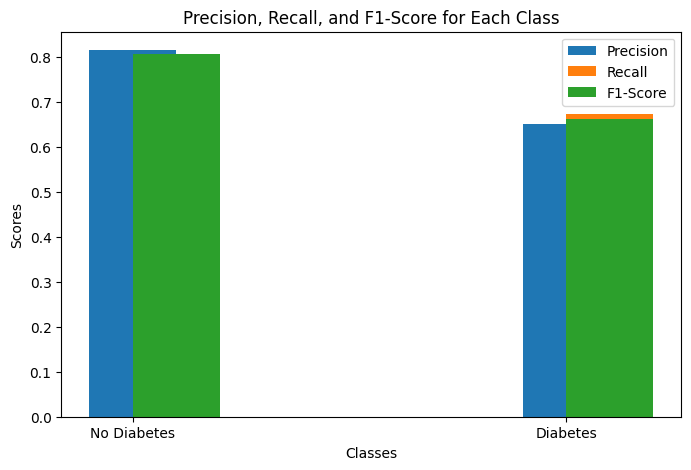

In [10]:
# Plot the results

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Plot Precision, Recall, F1-Score for each class
from sklearn.metrics import classification_report

# Get the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and F1-score for class 0 and class 1
precision = [report['0']['precision'], report['1']['precision']]
recall = [report['0']['recall'], report['1']['recall']]
f1_score = [report['0']['f1-score'], report['1']['f1-score']]

# Create a bar plot
labels = ['No Diabetes', 'Diabetes']
x = range(len(labels))

plt.figure(figsize=(8, 5))

# Plot Precision, Recall, and F1-Score
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar(x, recall, width=0.2, label='Recall', align='edge')
plt.bar(x, f1_score, width=0.2, label='F1-Score', align='edge')

# Set labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xticks(x, labels)
plt.legend()

plt.show()

valuate Fairness with Respect to Age Group in the Test Set

In [12]:
import numpy as np  # Import numpy module

# Define an age threshold for the synthetic demographic group (you can adjust this threshold)
age_threshold = 30

# Create synthetic demographic group based on Age for the test data
age_group_test = np.where(X_test[:, 7] > age_threshold, 1, 0)  # Column 7 corresponds to Age in X_test

# Now, evaluate fairness with respect to this synthetic "AgeGroup" (only for the test data)
# Separate the predictions based on the AgeGroup
y_pred_0 = y_pred[age_group_test == 0]  # Age group 0 (Age <= 30)
y_pred_1 = y_pred[age_group_test == 1]  # Age group 1 (Age > 30)
y_true_0 = y_test.values[age_group_test == 0]
y_true_1 = y_test.values[age_group_test == 1]

# Compute Demographic Parity: Proportion of positive predictions (1s) in each group
dp_0 = np.mean(y_pred_0) if len(y_pred_0) > 0 else 0
dp_1 = np.mean(y_pred_1) if len(y_pred_1) > 0 else 0

# Compute Equal Opportunity: Proportion of True Positives in each group, handling division by zero
tp_0 = np.sum((y_pred_0 == 1) & (y_true_0 == 1)) / np.sum(y_true_0 == 1) if np.sum(y_true_0 == 1) != 0 else 0
tp_1 = np.sum((y_pred_1 == 1) & (y_true_1 == 1)) / np.sum(y_true_1 == 1) if np.sum(y_true_1 == 1) != 0 else 0

# Display fairness metrics
print(f"Demographic Parity (Age <= 30): {dp_0:.4f}")
print(f"Demographic Parity (Age > 30): {dp_1:.4f}")
print(f"Equal Opportunity (Age <= 30): {tp_0:.4f}")
print(f"Equal Opportunity (Age > 30): {tp_1:.4f}")

Demographic Parity (Age <= 30): 0.3701
Demographic Parity (Age > 30): 0.0000
Equal Opportunity (Age <= 30): 0.6727
Equal Opportunity (Age > 30): 0.0000


Bias Mitigation

In [13]:
from sklearn.utils.class_weight import compute_sample_weight

# Step 5: Reweighting the Training Data

# Compute sample weights for the training data based on age group
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Now train the model again using these sample weights
model_reweighted = LogisticRegression(random_state=42)
model_reweighted.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions on the test set
y_pred_reweighted = model_reweighted.predict(X_test)

# Evaluate the reweighted model's performance
accuracy_reweighted = accuracy_score(y_test, y_pred_reweighted)
conf_matrix_reweighted = confusion_matrix(y_test, y_pred_reweighted)
class_report_reweighted = classification_report(y_test, y_pred_reweighted)

# Display the evaluation metrics for the reweighted model
print(f"Accuracy (Reweighted Model): {accuracy_reweighted:.4f}")
print("Confusion Matrix (Reweighted):")
print(conf_matrix_reweighted)
print("Classification Report (Reweighted):")
print(class_report_reweighted)

Accuracy (Reweighted Model): 0.6948
Confusion Matrix (Reweighted):
[[68 31]
 [16 39]]
Classification Report (Reweighted):
              precision    recall  f1-score   support

           0       0.81      0.69      0.74        99
           1       0.56      0.71      0.62        55

    accuracy                           0.69       154
   macro avg       0.68      0.70      0.68       154
weighted avg       0.72      0.69      0.70       154



Fairness Metrics

In [14]:
# Step 6: Reevaluate fairness after reweighting
y_pred_reweighted_0 = y_pred_reweighted[age_group_test == 0]  # Age group 0 (Age <= 30)
y_pred_reweighted_1 = y_pred_reweighted[age_group_test == 1]  # Age group 1 (Age > 30)
y_true_reweighted_0 = y_test.values[age_group_test == 0]
y_true_reweighted_1 = y_test.values[age_group_test == 1]

# Compute Demographic Parity: Proportion of positive predictions (1s) in each group
dp_0_reweighted = np.mean(y_pred_reweighted_0) if len(y_pred_reweighted_0) > 0 else 0
dp_1_reweighted = np.mean(y_pred_reweighted_1) if len(y_pred_reweighted_1) > 0 else 0

# Compute Equal Opportunity: Proportion of True Positives in each group, handling division by zero
tp_0_reweighted = np.sum((y_pred_reweighted_0 == 1) & (y_true_reweighted_0 == 1)) / np.sum(y_true_reweighted_0 == 1) if np.sum(y_true_reweighted_0 == 1) != 0 else 0
tp_1_reweighted = np.sum((y_pred_reweighted_1 == 1) & (y_true_reweighted_1 == 1)) / np.sum(y_true_reweighted_1 == 1) if np.sum(y_true_reweighted_1 == 1) != 0 else 0

# Display fairness metrics for the reweighted model
print(f"Demographic Parity (Age <= 30) after reweighting: {dp_0_reweighted:.4f}")
print(f"Demographic Parity (Age > 30) after reweighting: {dp_1_reweighted:.4f}")
print(f"Equal Opportunity (Age <= 30) after reweighting: {tp_0_reweighted:.4f}")
print(f"Equal Opportunity (Age > 30) after reweighting: {tp_1_reweighted:.4f}")

Demographic Parity (Age <= 30) after reweighting: 0.4545
Demographic Parity (Age > 30) after reweighting: 0.0000
Equal Opportunity (Age <= 30) after reweighting: 0.7091
Equal Opportunity (Age > 30) after reweighting: 0.0000


In [15]:
# Step 1: Train the model on the original (unbalanced) data
from sklearn.linear_model import LogisticRegression

model_unbalanced = LogisticRegression(random_state=42)
model_unbalanced.fit(X_train, y_train)

# Step 2: Make predictions and evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_unbalanced = model_unbalanced.predict(X_test)

# Evaluate the accuracy and other metrics
accuracy_unbalanced = accuracy_score(y_test, y_pred_unbalanced)
conf_matrix_unbalanced = confusion_matrix(y_test, y_pred_unbalanced)
class_report_unbalanced = classification_report(y_test, y_pred_unbalanced)

# Print the results
print(f"Accuracy (Unbalanced Model): {accuracy_unbalanced:.4f}")
print("Confusion Matrix (Unbalanced):")
print(conf_matrix_unbalanced)
print("Classification Report (Unbalanced):")
print(class_report_unbalanced)

# Step 3: Re-evaluate fairness metrics without resampling
y_pred_unbalanced_0 = y_pred_unbalanced[age_group_test == 0]  # Age group 0 (Age <= 30)
y_pred_unbalanced_1 = y_pred_unbalanced[age_group_test == 1]  # Age group 1 (Age > 30)
y_true_unbalanced_0 = y_test[age_group_test == 0]
y_true_unbalanced_1 = y_test[age_group_test == 1]

# Compute Demographic Parity
dp_0_unbalanced = np.mean(y_pred_unbalanced_0) if len(y_pred_unbalanced_0) > 0 else 0
dp_1_unbalanced = np.mean(y_pred_unbalanced_1) if len(y_pred_unbalanced_1) > 0 else 0

# Compute Equal Opportunity
tp_0_unbalanced = np.sum((y_pred_unbalanced_0 == 1) & (y_true_unbalanced_0 == 1)) / np.sum(y_true_unbalanced_0 == 1) if np.sum(y_true_unbalanced_0 == 1) != 0 else 0
tp_1_unbalanced = np.sum((y_pred_unbalanced_1 == 1) & (y_true_unbalanced_1 == 1)) / np.sum(y_true_unbalanced_1 == 1) if np.sum(y_true_unbalanced_1 == 1) != 0 else 0

# Display fairness metrics for the unbalanced model
print(f"Demographic Parity (Age <= 30) without resampling: {dp_0_unbalanced:.4f}")
print(f"Demographic Parity (Age > 30) without resampling: {dp_1_unbalanced:.4f}")
print(f"Equal Opportunity (Age <= 30) without resampling: {tp_0_unbalanced:.4f}")
print(f"Equal Opportunity (Age > 30) without resampling: {tp_1_unbalanced:.4f}")

Accuracy (Unbalanced Model): 0.7532
Confusion Matrix (Unbalanced):
[[79 20]
 [18 37]]
Classification Report (Unbalanced):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154

Demographic Parity (Age <= 30) without resampling: 0.3701
Demographic Parity (Age > 30) without resampling: 0.0000
Equal Opportunity (Age <= 30) without resampling: 0.6727
Equal Opportunity (Age > 30) without resampling: 0.0000


Reweight the Model's Loss Function

In [16]:
from sklearn.linear_model import LogisticRegression

# Calculate class weights for the unbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights based on the training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Step 1: Train the model with class weights
model_weighted = LogisticRegression(random_state=42, class_weight=class_weight_dict)
model_weighted.fit(X_train, y_train)

# Step 2: Make predictions and evaluate the model
y_pred_weighted = model_weighted.predict(X_test)

# Evaluate the accuracy and other metrics
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
class_report_weighted = classification_report(y_test, y_pred_weighted)

# Print the results
print(f"Accuracy (Weighted Model): {accuracy_weighted:.4f}")
print("Confusion Matrix (Weighted):")
print(conf_matrix_weighted)
print("Classification Report (Weighted):")
print(class_report_weighted)

# Step 3: Re-evaluate fairness metrics for the weighted model
y_pred_weighted_0 = y_pred_weighted[age_group_test == 0]  # Age group 0 (Age <= 30)
y_pred_weighted_1 = y_pred_weighted[age_group_test == 1]  # Age group 1 (Age > 30)
y_true_weighted_0 = y_test[age_group_test == 0]
y_true_weighted_1 = y_test[age_group_test == 1]

# Compute Demographic Parity for the weighted model
dp_0_weighted = np.mean(y_pred_weighted_0) if len(y_pred_weighted_0) > 0 else 0
dp_1_weighted = np.mean(y_pred_weighted_1) if len(y_pred_weighted_1) > 0 else 0

# Compute Equal Opportunity for the weighted model
tp_0_weighted = np.sum((y_pred_weighted_0 == 1) & (y_true_weighted_0 == 1)) / np.sum(y_true_weighted_0 == 1) if np.sum(y_true_weighted_0 == 1) != 0 else 0
tp_1_weighted = np.sum((y_pred_weighted_1 == 1) & (y_true_weighted_1 == 1)) / np.sum(y_true_weighted_1 == 1) if np.sum(y_true_weighted_1 == 1) != 0 else 0

# Display fairness metrics for the weighted model
print(f"Demographic Parity (Age <= 30) with reweighted model: {dp_0_weighted:.4f}")
print(f"Demographic Parity (Age > 30) with reweighted model: {dp_1_weighted:.4f}")
print(f"Equal Opportunity (Age <= 30) with reweighted model: {tp_0_weighted:.4f}")
print(f"Equal Opportunity (Age > 30) with reweighted model: {tp_1_weighted:.4f}")

Accuracy (Weighted Model): 0.6948
Confusion Matrix (Weighted):
[[68 31]
 [16 39]]
Classification Report (Weighted):
              precision    recall  f1-score   support

           0       0.81      0.69      0.74        99
           1       0.56      0.71      0.62        55

    accuracy                           0.69       154
   macro avg       0.68      0.70      0.68       154
weighted avg       0.72      0.69      0.70       154

Demographic Parity (Age <= 30) with reweighted model: 0.4545
Demographic Parity (Age > 30) with reweighted model: 0.0000
Equal Opportunity (Age <= 30) with reweighted model: 0.7091
Equal Opportunity (Age > 30) with reweighted model: 0.0000


In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Create a column 'AgeGroup' (0 for Age <= 30, 1 for Age > 30)
data['AgeGroup'] = (data['Age'] > 30).astype(int)

# Split the data into features (X) and target (y)
X = data.drop(columns=['Outcome'])  # Features (AgeGroup will be included for fairness evaluation)
y = data['Outcome']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now let's compute the sample weights based on the age group (we will assign higher weights to underrepresented groups)
# Compute weights based on age group and outcome (you can adjust this to reflect the fairness goals)
age_weights = X_train['Age'].apply(lambda x: 2 if x > 30 else 1)

# You can also factor in the outcome (e.g., giving higher weight to minority classes)
# For example, you can reweight based on class imbalance:
y_weights = y_train.apply(lambda x: 1 if x == 0 else 2)  # Giving more weight to class 1

# Combine both weight sources (adjust this based on your specific fairness goals)
sample_weights = age_weights * y_weights

# Train the Logistic Regression model with sample weights
model = LogisticRegression(solver='liblinear')
model.fit(X_train.drop(columns=['AgeGroup']), y_train, sample_weight=sample_weights)  # Drop AgeGroup column for training

# Make predictions on the test set
y_pred = model.predict(X_test.drop(columns=['AgeGroup']))  # Drop AgeGroup column for predictions

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Fairness evaluation (Demographic Parity and Equal Opportunity based on AgeGroup)
# Demographic Parity: Difference in positive rates between groups
demographic_parity_0 = np.mean(y_pred[X_test['AgeGroup'] == 0])
demographic_parity_1 = np.mean(y_pred[X_test['AgeGroup'] == 1])

# Equal Opportunity: Difference in true positive rates between groups
true_positive_rate_0 = np.mean((y_pred[X_test['AgeGroup'] == 0] == 1) & (y_test[X_test['AgeGroup'] == 0] == 1))
true_positive_rate_1 = np.mean((y_pred[X_test['AgeGroup'] == 1] == 1) & (y_test[X_test['AgeGroup'] == 1] == 1))

# Print results
print(f"Accuracy (Reweighted Model): {accuracy}")
print(f"Confusion Matrix (Reweighted): \n{conf_matrix}")
print(f"Classification Report (Reweighted): \n{class_report}")
print(f"Demographic Parity (Age <= 30): {demographic_parity_0}")
print(f"Demographic Parity (Age > 30): {demographic_parity_1}")
print(f"Equal Opportunity (Age <= 30): {true_positive_rate_0}")
print(f"Equal Opportunity (Age > 30): {true_positive_rate_1}")

Accuracy (Reweighted Model): 0.6883116883116883
Confusion Matrix (Reweighted): 
[[64 35]
 [13 42]]
Classification Report (Reweighted): 
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        99
           1       0.55      0.76      0.64        55

    accuracy                           0.69       154
   macro avg       0.69      0.71      0.68       154
weighted avg       0.73      0.69      0.69       154

Demographic Parity (Age <= 30): 0.2716049382716049
Demographic Parity (Age > 30): 0.7534246575342466
Equal Opportunity (Age <= 30): 0.14814814814814814
Equal Opportunity (Age > 30): 0.410958904109589


Fairness Constraints

In [23]:
# Import necessary libraries
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Define fairness constraints (choose the fairness metric you want)
# We can use 'DemographicParity' or 'EqualizedOdds' for fairness constraints.

fairness_constraint = DemographicParity()  # You can also use EqualizedOdds()

# Step 2: Train the model with fairness constraints
# Use a logistic regression classifier or any other model you prefer
classifier = LogisticRegression(solver='liblinear')

# Create the ExponentiatedGradient model with fairness constraints
debiasing_model = ExponentiatedGradient(classifier, fairness_constraint)

# Step 3: Fit the model
# Fit the model to the training data with the sensitive attribute 'AgeGroup'
debiasing_model.fit(X_train, y_train, sensitive_features=age_group_train)

# Step 4: Predict on test data
y_pred = debiasing_model.predict(X_test)

# Step 5: Evaluate the model's accuracy and fairness
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Step 6: Evaluate fairness metrics
# Check fairness using demographic parity or equalized odds
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=age_group_test)
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=age_group_test)

# Output the results
print("Accuracy with Fairness Constraints: {:.4f}".format(accuracy))
print("Confusion Matrix with Fairness Constraints:\n", conf_matrix)
print("Classification Report with Fairness Constraints:\n", class_report)
print("Demographic Parity Difference: {:.4f}".format(dp_diff))
print("Equalized Odds Difference: {:.4f}".format(eo_diff))

Accuracy with Fairness Constraints: 0.7013
Confusion Matrix with Fairness Constraints:
 [[87 12]
 [34 21]]
Classification Report with Fairness Constraints:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79        99
           1       0.64      0.38      0.48        55

    accuracy                           0.70       154
   macro avg       0.68      0.63      0.63       154
weighted avg       0.69      0.70      0.68       154

Demographic Parity Difference: 0.0167
Equalized Odds Difference: 0.0756


Testing Equal Opportunity (Recall-Based Fairness Metric)

In [24]:
from sklearn.metrics import recall_score

# Step 1: Calculate recall for each age group
# For Age <= 30 (Age Group 0)
recall_age_0 = recall_score(y_test[age_group_test == 0], y_pred[age_group_test == 0])
# For Age > 30 (Age Group 1)
recall_age_1 = recall_score(y_test[age_group_test == 1], y_pred[age_group_test == 1])

print(f"Recall (Age <= 30): {recall_age_0}")
print(f"Recall (Age > 30): {recall_age_1}")

# Step 2: Equal Opportunity Difference
equal_opportunity_diff = abs(recall_age_0 - recall_age_1)
print(f"Equal Opportunity Difference: {equal_opportunity_diff}")

Recall (Age <= 30): 0.42857142857142855
Recall (Age > 30): 0.35294117647058826
Equal Opportunity Difference: 0.07563025210084029


Hyperparameter Tuning for Fairness

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from fairlearn.reductions import GridSearch, DemographicParity

# Initialize the classifier (we'll use DecisionTree for simplicity)
classifier = DecisionTreeClassifier(random_state=42)

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# Set up the fairness constraint (Demographic Parity or Equal Opportunity)
fairness_constraint = DemographicParity()

# Set up the GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# Use the best model to evaluate fairness metrics again
best_classifier = grid_search.best_estimator_

# Predict with the best classifier
y_pred_best = best_classifier.predict(X_test)

# Calculate fairness metrics
recall_age_0_best = recall_score(y_test[age_group_test == 0], y_pred_best[age_group_test == 0])
recall_age_1_best = recall_score(y_test[age_group_test == 1], y_pred_best[age_group_test == 1])

# Print the updated recall and fairness metric
print(f"Updated Recall (Age <= 30): {recall_age_0_best}")
print(f"Updated Recall (Age > 30): {recall_age_1_best}")
equal_opportunity_diff_best = abs(recall_age_0_best - recall_age_1_best)
print(f"Updated Equal Opportunity Difference: {equal_opportunity_diff_best}")

Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.7573903771824604
Updated Recall (Age <= 30): 0.47619047619047616
Updated Recall (Age > 30): 0.7058823529411765
Updated Equal Opportunity Difference: 0.22969187675070035
